In [9]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import gsw
from matplotlib.ticker import MaxNLocator

import cartopy as cart
import cartopy.crs as ccrs
import cmocean.cm as cmo
import seaborn as sns
from glob import glob
import cartopy.feature as cfeature
import matplotlib
import toolbox

In [102]:
sim = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/set_16/set16_2500.zarr/')
sim = sim.compute()

In [103]:
def filter_trajectories(data, condition, last_index=False):
    k, _ = np.where(condition)
    index = np.unique(k)
    
    data_relevant = data.where(data['trajectory'].isin(index), drop=True)

    return data_relevant

In [104]:
shelf = filter_trajectories(sim, sim['seafloor'] < 200)

In [105]:
shelf

<xarray.Dataset>
Dimensions:           (traj: 19, obs: 4856)
Dimensions without coordinates: traj, obs
Data variables: (12/19)
    Kz                (traj, obs) float32 9.771e-05 6.009e-05 ... 0.01611
    abs_salinity      (traj, obs) float32 34.74 34.74 34.74 ... 35.42 35.43
    cons_temperature  (traj, obs) float32 0.725 0.7254 0.7212 ... 18.86 18.93
    density           (traj, obs) float32 1.028e+03 1.028e+03 ... 1.025e+03
    diameter          (traj, obs) float64 5.021e-08 5.021e-08 ... 1.302e-05
    lat               (traj, obs) float64 -32.17 -32.15 -32.11 ... -36.41 -36.41
    ...                ...
    u                 (traj, obs) float32 4.897e-07 4.266e-07 ... -1.839e-06
    v                 (traj, obs) float32 -2.033e-07 -3.349e-07 ... -1.859e-06
    v_s               (traj, obs) float32 0.0 4.702e-10 4.702e-10 ... 0.0 0.0
    w                 (traj, obs) float32 -0.0002963 -0.0003353 ... -2.744e-06
    w_k               (traj, obs) float32 0.0 0.0 0.0 ... 0.02446 0.01993
    z                 (traj, obs) float64 5.17e+03 5.124e+03 ... 10.41 10.41
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-303-gd31c5f32

(-10.0, 3200.0)

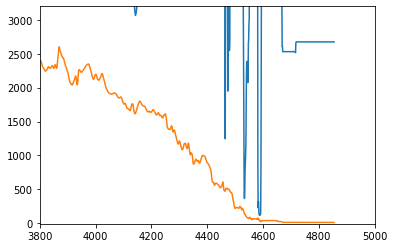

In [108]:
plt.plot(shelf['seafloor'][4, :])
plt.plot(shelf['z'][4, :])
plt.xlim(3800, 5000)
plt.ylim(-10, 3200)

In [81]:
shp_dict = {}
files = glob('../data/ne_10m_bathymetry_all/*.shp')
assert len(files) > 0
files.sort()
for f in files:
    depth = f.split('_')[-1].split('.')[0]
    # depth = '-' + f.split('_')[-1].split('.')[0]
    # depths.append(depth)
    nei = cart.io.shapereader.Reader(f)
    shp_dict[depth] = nei

depths = [d for d in shp_dict.keys()][::-1]
colors = sns.mpl_palette('cmo.ice_r',n_colors=8)
cmap   = sns.mpl_palette('cmo.ice',n_colors=8,as_cmap=True)
max_depth = -6000
min_depth = 0 

4855


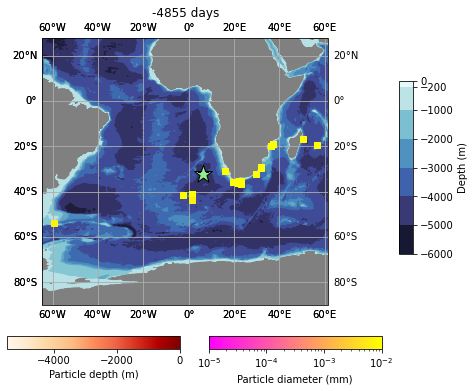

In [109]:
dt = 5
end_frame = 4855

for k, frame in enumerate(range(end_frame, end_frame-1, -dt)):   #i, frame in range(0,2900, dt):
    print(f'{frame:03d}')

    fig = plt.figure(figsize=(8,6))
    gs = fig.add_gridspec(2, 2,  width_ratios=(8, 2), height_ratios=(8, 2),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.07, hspace=0.07)

    ax = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5)

    i = 0
    for depth in depths[:8]:
        ax.add_geometries(shp_dict[depth].geometries(),crs=ccrs.PlateCarree(),color=colors[i])
        i+=1

    ax.add_feature(cart.feature.NaturalEarthFeature(category='physical',name='land',scale='110m'),color='grey',
                  zorder=0)

    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False

    # Add custom colorbar
    axi = fig.add_axes([0.78,0.4,0.025,0.4])
    # axi = fig.add_axes([0.8,0.2,0.025,0.6])
    norm = matplotlib.colors.Normalize(vmin=-6000,vmax=0)
    cbar = matplotlib.colorbar.ColorbarBase(ax=axi,cmap=cmap,norm=norm,
            boundaries=(-np.array(depths[:8]).astype(int)).tolist()[::-1],
            ticks=-np.array(depths).astype(int),
            spacing='proportional',
            extend='neither',
            label='Depth (m)'
            )

    ax.scatter(6.287, -32.171, marker='*',
               zorder=5, color='lightgreen', 
               label='32.171°S, 6.287°E  \n Depth: -5000m \n January 2020', 
               s=350, edgecolors='black')
    
    ax.set_title(f'-{frame} days')

    window = 15
#---
#     if frame - window < 0: # backwards
#         shadow = 0
#         trail = frame
#     else:
#         shadow = frame - window
#         trail = window

    if frame + window > end_frame:  # forward
        shadow = end_frame
        trail = end_frame - frame
        
    else:
        shadow = frame + window
        trail = window

# Backwards
#     im = ax.scatter(shelf['lon'][:,shadow:frame].T, shelf['lat'][:,shadow:frame].T, 
#                c=-shelf['z'][:,shadow:frame].T, zorder=5, s=np.array([np.linspace(1, 41, trail)]*8).T, 
#                     cmap='OrRd',
#                    vmax=0, vmin=-5500)

    # Forward
    min_lon, max_lon = shelf['lon'][:,frame].min().values, shelf['lon'][:,frame].max().values
    min_lat, max_lat = shelf['lat'][:,frame].min().values, shelf['lat'][:,frame].max().values
    
#     print(min_lon, max_lon, min_lat, max_lat)
    dlon = abs(min_lon - max_lon)
    dlat = abs(min_lat - max_lat)
    difference = abs(dlat - dlon)/2
    margin = 5
    
    if dlat > dlon:
#         print(1)
        min_lon -= abs(difference + margin)
        max_lon += abs(difference + margin)
        min_lat -= margin
        max_lat += margin
        
    else:
#         print(2, difference)
        min_lat -= abs(difference + margin)
        max_lat += abs(difference + margin)
        min_lon -= margin
        max_lon += margin
    

#     print(dlon, dlat)
#     print(min_lon, max_lon, min_lat, max_lat)
    
    im = ax.scatter(shelf['lon'][:,frame:shadow].T, shelf['lat'][:,frame:shadow].T, 
           c=-shelf['z'][:,frame:shadow].T, zorder=5, s=np.array([np.linspace(41, 1, trail)]*8).T, 
                cmap='OrRd',
               vmax=0, vmin=-5500)
    #----
    im2 = ax.scatter(shelf['lon'][:,frame], shelf['lat'][:,frame], 
                    c=shelf['diameter'][:,frame]*1000, 
                    zorder=5, cmap='spring', norm=matplotlib.colors.LogNorm(vmax=1e-2, vmin=1e-5),
                    marker='s')
    
    ax.set_extent((min_lon, max_lon, min_lat, max_lat), crs=ccrs.PlateCarree())

    bar_ax = fig.add_axes([0.1, 0.18, 0.3, 0.03])
    fig.colorbar(im, cax=bar_ax, orientation='horizontal', label='Particle depth (m)')

    bar_ax2 = fig.add_axes([0.45, 0.18, 0.3, 0.03])
    fig.colorbar(im2, cax=bar_ax2, orientation='horizontal', label='Particle diameter (mm)')
    # ax.set_title('10 years before sampling', fontsize=15, weight='bold')
    num = k #frame//dt
#     plt.savefig(f'../figs/contishelf_reverse/{num:03d}', dpi=100, facecolor=(1,1,1,1))
#     plt.close()

In [34]:
min_lon

array(6.54380333)

In [10]:
max_sal, min_sal = sim_['abs_salinity'].max(), 32
max_temp, min_temp = sim_['cons_temperature'].max(), 0

tempL = np.linspace(min_temp - 1, max_temp + 1, 156)
salL = np.linspace(min_sal - 1, max_sal + 1, 156)
Tg, Sg = np.meshgrid(tempL,salL)

sigma_theta = gsw.sigma0(Sg, Tg)
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(), 156)

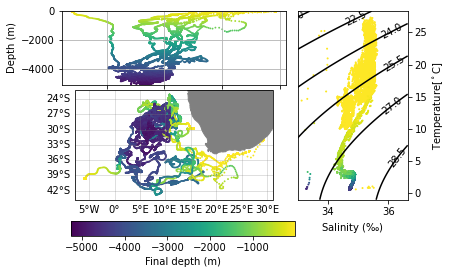

In [13]:
frame = 0
n_day = 360

fig = plt.figure(figsize=(6,4))
gs = fig.add_gridspec(3, 2,  width_ratios=(6.1, 3), height_ratios=(2, 3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.07, hspace=0.07)

ax = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
# ax.set_extent((-45, 46, -52, -16))
ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5)
gl.right_labels = False
gl.top_labels = False

ax_lon = plt.subplot(gs[0, 0], sharex=ax)
ax_lon.grid()
ax_lon.set_xticklabels([])
ax_lon.set_ylabel('Depth (m)')
ax_lon.set_ylim(-5100, 0)


ax_TS = fig.add_subplot(gs[:2, 1])
ax_TS.scatter(sim_['abs_salinity'], sim_['cons_temperature'], s=1, c=-sim_['z']);
ax_TS.set_xlim(33, max_sal + 1)
ax_TS.yaxis.tick_right()
ax_TS.yaxis.set_label_position("right")
cs = ax_TS.contour(Sg, Tg, sigma_theta, colors='k', zorder=1)
cl = plt.clabel(cs, fontsize=10, inline=False, fmt='%.1f')

ax_TS.set_xlabel('Salinity ($‰$)')
ax_TS.set_ylabel('Temperature[$^\circ$C]')

size_point = 0.7
im = ax.scatter(sim_['lon'], sim_['lat'], c=-sim_['z'], s=size_point)
ax_lon.scatter(sim_['lon'], -sim_['z'], c=-sim_['z'], s=size_point)
# ax_lat.scatter(-sim_['depth'], sim_['lat'], c=-sim_['depth'], s=size_point)

bar_ax = fig.add_axes([0.12, 0.12, 0.52, 0.05])
plt.colorbar(im, cax=bar_ax, orientation='horizontal', label='Final depth (m)')


In [30]:
for frame in range(0,11, 10):
#     sim_= np.load(f'/storage/shared/oceanparcels/output_data/data_Claudio/frag_runs/', allow_pickle=True).item()
    print(f'{frame:03d}')
    size_point = 0.7

    fig = plt.figure(figsize=(6,8))
    gs = fig.add_gridspec(3, 2,  width_ratios=(5,5), height_ratios=(3, 3, 1),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.1, hspace=0.3)

    # Map
    ax = fig.add_subplot(gs[1, 0:2], projection=ccrs.PlateCarree())
    # ax.set_extent((-45, 46, -52, -16))
    ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5)
    gl.right_labels = False
    gl.top_labels = False
    im = ax.scatter(sim_['lon'], sim_['lat'], c=-sim_['depth'], s=size_point, vmax=0, vmin=-2000)

    # Depth distributions
    ax_lon = plt.subplot(gs[0, 0])
    ax_lon.grid()
    # ax_lon.set_xticklabels([])
    ax_lon.set_xlabel('Depth (m)')
    ax_lon.set_ylabel('Number of Particles')
    ax_lon.set_xlim(-2000, 0)
    ax_lon.hist(-sim_['depth'], bins=40)

    # T-S diagram
    ax_TS = plt.subplot(gs[0, 1])
    ax_TS.scatter(sim_['abs_salinity'], sim_['cons_temperature'], s=size_point, c=-sim_['depth'],
                 vmax=0, vmin=-2000);
    ax_TS.set_xlim(33, max_sal + 1)
    ax_TS.yaxis.tick_right()
    ax_TS.yaxis.set_label_position("right")
    cs = ax_TS.contour(Sg, Tg, sigma_theta, colors='k', zorder=1)
    cl = plt.clabel(cs, fontsize=10, inline=False, fmt='%.1f')
    ax_TS.set_xlabel('Salinity ($‰$)')
    ax_TS.set_ylabel('Temperature[$^\circ$C]')

    # Colobar
    bar_ax = fig.add_axes([0.12, 0.17, 0.78, 0.04])
    plt.colorbar(im, cax=bar_ax, orientation='horizontal', label='Depth (m)')
    num = frame//10
#     plt.savefig(f'../figs/60m/{num:03d}', dpi=50, facecolor=(1,1,1,1))
#     plt.close()

000
010
020
030
040
050
060
070
080
090
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790


In [ ]:
sim = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/frag_runs/0W36KD.nc')
sim = toolbox.stuck_particles_mask(sim)

In [7]:
sim

<xarray.Dataset>
Dimensions:           (traj: 50000, obs: 3651)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory        (traj, obs) float64 0.0 0.0 0.0 0.0 ... 5e+04 5e+04 5e+04
    time              (traj, obs) datetime64[ns] 2019-12-30T12:00:00 ... 2010...
    lat               (traj, obs) float64 -32.15 -32.12 -32.08 ... -33.73 -33.74
    lon               (traj, obs) float64 6.295 6.353 6.37 ... -0.2144 -0.2338
    z                 (traj, obs) float64 5.179e+03 5.185e+03 ... 4.293e+03
    cons_temperature  (traj, obs) float32 0.7166 0.7281 0.7275 ... 0.7073 0.7133
    abs_salinity      (traj, obs) float32 34.74 34.74 34.74 ... 34.74 34.74
    mld               (traj, obs) float32 33.11 50.49 50.82 ... 17.87 10.74
    alpha             (traj, obs) float32 1e-06 1e-06 1e-06 ... 1e-06 1e-06
    density           (traj, obs) float32 1.035e+03 1.028e+03 ... 1.028e+03
    v_s               (traj, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        v2.3.0-71-g202ef087
    parcels_mesh:           spherical

In [ ]:
max_sal, min_sal = sim['abs_salinity'].max(), 32
max_temp, min_temp = sim['cons_temperature'].max(), 0

tempL = np.linspace(min_temp - 1, max_temp + 1, 156)
salL = np.linspace(min_sal - 1, max_sal + 1, 156)
Tg, Sg = np.meshgrid(tempL,salL)

sigma_theta = gsw.sigma0(Sg, Tg)
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(), 156)

for frame in range(0, 3651, 10):
#     print(f'{frame:03d}')
    size_point = 0.7

    fig = plt.figure(figsize=(6,8))
    gs = fig.add_gridspec(3, 2,  width_ratios=(5,5), height_ratios=(3, 3, 1),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.1, hspace=0.3)

    # Map
    ax = fig.add_subplot(gs[1, 0:2], projection=ccrs.PlateCarree())
    # ax.set_extent((-45, 46, -52, -16))
    ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5)
    gl.right_labels = False
    gl.top_labels = False
    im = ax.scatter(sim['lon'][:, frame], sim['lat'][:, frame], c=-sim['z'][:, frame], s=size_point, vmax=0, vmin=-5500)

    # Depth distributions
    ax_lon = plt.subplot(gs[0, 0])
    ax_lon.grid()
    # ax_lon.set_xticklabels([])
    ax_lon.set_xlabel('Depth (m)')
    ax_lon.set_ylabel('Number of Particles')
    ax_lon.set_xlim(-5500, 0)
    ax_lon.set_ylim(0, 15000)
    ax_lon.hist(-sim['z'][:, frame], bins=40)
    time_str = str(sim['time'][0,frame].values)[:10]
    ax_lon.set_title(time_str)

    # T-S diagram
    ax_TS = plt.subplot(gs[0, 1])
    ax_TS.scatter(sim['abs_salinity'][:, frame], sim['cons_temperature'][:, frame], s=size_point, c=-sim['z'][:, frame],
                 vmax=0, vmin=-5500);
    ax_TS.set_xlim(33, max_sal + 1)
    ax_TS.yaxis.tick_right()
    ax_TS.yaxis.set_label_position("right")
    cs = ax_TS.contour(Sg, Tg, sigma_theta, colors='k', zorder=1)
    cl = plt.clabel(cs, fontsize=10, inline=False, fmt='%.1f')
    ax_TS.set_xlabel('Salinity ($‰$)')
    ax_TS.set_ylabel('Temperature[$^\circ$C]')

    # Colobar
    bar_ax = fig.add_axes([0.12, 0.17, 0.78, 0.04])
    plt.colorbar(im, cax=bar_ax, orientation='horizontal', label='Depth (m)')
    num = frame//10
    plt.savefig(f'../figs/5173m/{num:03d}', dpi=200, facecolor=(1,1,1,1))
    plt.close()

# 60m

In [12]:
sim60 = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/backtrack_SA/SA_60m_t3650_diff-False.nc')
sim60 = toolbox.stuck_particles_mask(sim60)

In [ ]:
max_sal, min_sal = sim60['abs_salinity'].max(), 32
max_temp, min_temp = sim60['cons_temperature'].max(), 0

tempL = np.linspace(min_temp - 1, max_temp + 1, 156)
salL = np.linspace(min_sal - 1, max_sal + 1, 156)
Tg, Sg = np.meshgrid(tempL,salL)

sigma_theta = gsw.sigma0(Sg, Tg)
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(), 156)

for frame in range(0, 3651, 10):
#     print(f'{frame:03d}')
    size_point = 0.7

    fig = plt.figure(figsize=(6,8))
    gs = fig.add_gridspec(3, 2,  width_ratios=(5,5), height_ratios=(3, 3, 1),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.1, hspace=0.3)

    # Map
    ax = fig.add_subplot(gs[1, 0:2], projection=ccrs.PlateCarree())
    # ax.set_extent((-45, 46, -52, -16))
    ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5)
    gl.right_labels = False
    gl.top_labels = False
    im = ax.scatter(sim60['lon'][:, frame], sim60['lat'][:, frame], c=-sim60['z'][:, frame], s=size_point, vmax=0, vmin=-5500)

    # Depth distributions
    ax_lon = plt.subplot(gs[0, 0])
    ax_lon.grid()
    # ax_lon.set_xticklabels([])
    ax_lon.set_xlabel('Depth (m)')
    ax_lon.set_ylabel('Number of Particles')
    ax_lon.set_xlim(-5500, 0)
    ax_lon.set_ylim(0, 15000)
    ax_lon.hist(-sim60['z'][:, frame], bins=40)
    time_str = str(sim60['time'][0,frame].values)[:10]
    ax_lon.set_title(time_str)

    # T-S diagram
    ax_TS = plt.subplot(gs[0, 1])
    ax_TS.scatter(sim60['abs_salinity'][:, frame], sim60['cons_temperature'][:, frame], s=size_point, c=-sim60['z'][:, frame],
                 vmax=0, vmin=-5500);
    ax_TS.set_xlim(33, max_sal + 1)
    ax_TS.yaxis.tick_right()
    ax_TS.yaxis.set_label_position("right")
    cs = ax_TS.contour(Sg, Tg, sigma_theta, colors='k', zorder=1)
    cl = plt.clabel(cs, fontsize=10, inline=False, fmt='%.1f')
    ax_TS.set_xlabel('Salinity ($‰$)')
    ax_TS.set_ylabel('Temperature[$^\circ$C]')

    # Colobar
    bar_ax = fig.add_axes([0.12, 0.17, 0.78, 0.04])
    plt.colorbar(im, cax=bar_ax, orientation='horizontal', label='Depth (m)')
    num = frame//10
    plt.savefig(f'../figs/60m/{num:03d}', dpi=200, facecolor=(1,1,1,1))
    plt.close()

! zip -r ../figs/60m.zip ../figs/60m/



# 5179m with diffussion

In [2]:
sim_diff = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/backtrack_SA/SA_5179m_t3650_diff_no_no.nc')
sim_diff = toolbox.stuck_particles_mask(sim_diff)

In [4]:
max_sal, min_sal = sim_diff['abs_salinity'].max(), 32
max_temp, min_temp = sim_diff['cons_temperature'].max(), 0

tempL = np.linspace(min_temp - 1, max_temp + 1, 156)
salL = np.linspace(min_sal - 1, max_sal + 1, 156)
Tg, Sg = np.meshgrid(tempL,salL)

sigma_theta = gsw.sigma0(Sg, Tg)
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(), 156)

for frame in range(0, 3651, 10):
#     print(f'{frame:03d}')
    size_point = 0.7

    fig = plt.figure(figsize=(6,8))
    gs = fig.add_gridspec(3, 2,  width_ratios=(5,5), height_ratios=(3, 3, 1),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.1, hspace=0.3)

    # Map
    ax = fig.add_subplot(gs[1, 0:2], projection=ccrs.PlateCarree())
    # ax.set_extent((-45, 46, -52, -16))
    ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5)
    gl.right_labels = False
    gl.top_labels = False
    im = ax.scatter(sim_diff['lon'][:, frame], sim_diff['lat'][:, frame], c=-sim_diff['z'][:, frame], s=size_point, vmax=0, vmin=-5500)

    # Depth distributions
    ax_lon = plt.subplot(gs[0, 0])
    ax_lon.grid()
    # ax_lon.set_xticklabels([])
    ax_lon.set_xlabel('Depth (m)')
    ax_lon.set_ylabel('Number of Particles')
    ax_lon.set_xlim(-5500, 0)
    ax_lon.set_ylim(0, 3000)
    ax_lon.hist(-sim_diff['z'][:, frame], bins=40)
    time_str = str(sim_diff['time'][0,frame].values)[:10]
    ax_lon.set_title(time_str)

    # T-S diagram
    ax_TS = plt.subplot(gs[0, 1])
    ax_TS.scatter(sim_diff['abs_salinity'][:, frame], sim_diff['cons_temperature'][:, frame], s=size_point, c=-sim_diff['z'][:, frame],
                 vmax=0, vmin=-5500);
    ax_TS.set_xlim(33, max_sal + 1)
    ax_TS.yaxis.tick_right()
    ax_TS.yaxis.set_label_position("right")
    cs = ax_TS.contour(Sg, Tg, sigma_theta, colors='k', zorder=1)
    cl = plt.clabel(cs, fontsize=10, inline=False, fmt='%.1f')
    ax_TS.set_xlabel('Salinity ($‰$)')
    ax_TS.set_ylabel('Temperature[$^\circ$C]')

    # Colobar
    bar_ax = fig.add_axes([0.12, 0.17, 0.78, 0.04])
    plt.colorbar(im, cax=bar_ax, orientation='horizontal', label='Depth (m)')
    num = frame//10
    plt.savefig(f'../figs/5173m-diff/{num:03d}', dpi=200, facecolor=(1,1,1,1))
    plt.close()

# 5179m settling velocity

In [15]:
sim_vs = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/backtrack_SA/SA_5179m_t3650_no_v_s_no.nc')
sim_vs = toolbox.stuck_particles_mask(sim_vs)

In [17]:
str(sim_vs['time'][0,30].values)[:10]

'2019-11-30'

In [18]:
max_sal, min_sal = sim_vs['abs_salinity'].max(), 32
max_temp, min_temp = sim_vs['cons_temperature'].max(), 0

tempL = np.linspace(min_temp - 1, max_temp + 1, 156)
salL = np.linspace(min_sal - 1, max_sal + 1, 156)
Tg, Sg = np.meshgrid(tempL,salL)

sigma_theta = gsw.sigma0(Sg, Tg)
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(), 156)

for frame in range(0, 3651, 10):
#     print(f'{frame:03d}')
    size_point = 0.7

    fig = plt.figure(figsize=(6,8))
    gs = fig.add_gridspec(3, 2,  width_ratios=(5,5), height_ratios=(3, 3, 1),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.1, hspace=0.3)

    # Map
    ax = fig.add_subplot(gs[1, 0:2], projection=ccrs.PlateCarree())
    # ax.set_extent((-45, 46, -52, -16))
    ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5)
    gl.right_labels = False
    gl.top_labels = False
    im = ax.scatter(sim_vs['lon'][:, frame], sim_vs['lat'][:, frame], c=-sim_vs['z'][:, frame], s=size_point, vmax=0, vmin=-5500)

    # Depth distributions
    ax_lon = plt.subplot(gs[0, 0])
    ax_lon.grid()
    # ax_lon.set_xticklabels([])
    ax_lon.set_xlabel('Depth (m)')
    ax_lon.set_ylabel('Number of Particles')
    ax_lon.set_xlim(-5500, 0)
    ax_lon.set_ylim(0, 3000)
    ax_lon.hist(-sim_vs['z'][:, frame], bins=40)
    time_str = str(sim_vs['time'][0,frame].values)[:10]
    print(time_str)
    ax_lon.set_title(time_str)

    # T-S diagram
    ax_TS = plt.subplot(gs[0, 1])
    ax_TS.scatter(sim_vs['abs_salinity'][:, frame], sim_vs['cons_temperature'][:, frame], s=size_point, c=-sim_vs['z'][:, frame],
                 vmax=0, vmin=-5500);
    ax_TS.set_xlim(33, max_sal + 1)
    ax_TS.yaxis.tick_right()
    ax_TS.yaxis.set_label_position("right")
    cs = ax_TS.contour(Sg, Tg, sigma_theta, colors='k', zorder=1)
    cl = plt.clabel(cs, fontsize=10, inline=False, fmt='%.1f')
    ax_TS.set_xlabel('Salinity ($‰$)')
    ax_TS.set_ylabel('Temperature[$^\circ$C]')

    # Colobar
    bar_ax = fig.add_axes([0.12, 0.17, 0.78, 0.04])
    plt.colorbar(im, cax=bar_ax, orientation='horizontal', label='Depth (m)')
    num = frame//10
    plt.savefig(f'../figs/5173m-vs/{num:03d}', dpi=200, facecolor=(1,1,1,1))
    plt.close()

2019-12-30
2019-12-20
2019-12-10
2019-11-30
2019-11-20
2019-11-10
2019-10-31
2019-10-21
2019-10-11
2019-10-01
2019-09-21
2019-09-11
2019-09-01
2019-08-22
2019-08-12
2019-08-02
2019-07-23
2019-07-13
2019-07-03
2019-06-23
2019-06-13
2019-06-03
2019-05-24
2019-05-14
2019-05-04
2019-04-24
2019-04-14
2019-04-04
2019-03-25
2019-03-15
2019-03-05
2019-02-23
2019-02-13
2019-02-03
2019-01-24
2019-01-14
2019-01-04
2018-12-25
2018-12-15
2018-12-05
2018-11-25
2018-11-15
2018-11-05
2018-10-26
2018-10-16
2018-10-06
2018-09-26
2018-09-16
2018-09-06
2018-08-27
2018-08-17
2018-08-07
2018-07-28
2018-07-18
2018-07-08
2018-06-28
2018-06-18
2018-06-08
2018-05-29
2018-05-19
2018-05-09
2018-04-29
2018-04-19
2018-04-09
2018-03-30
2018-03-20
2018-03-10
2018-02-28
2018-02-18
2018-02-08
2018-01-29
2018-01-19
2018-01-09
2017-12-30
2017-12-20
2017-12-10
2017-11-30
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
N

# 5179m settling velocity and fragmentation

In [11]:
sim_frag = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/backtrack_SA/SA_5179m_t3650_no_v_s_frag.nc')
sim_frag = toolbox.stuck_particles_mask(sim_frag)

In [13]:
max_sal, min_sal = sim_frag['abs_salinity'].max(), 32
max_temp, min_temp = sim_frag['cons_temperature'].max(), 0

tempL = np.linspace(min_temp - 1, max_temp + 1, 156)
salL = np.linspace(min_sal - 1, max_sal + 1, 156)
Tg, Sg = np.meshgrid(tempL,salL)

sigma_theta = gsw.sigma0(Sg, Tg)
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(), 156)

for frame in range(0, 3651, 10):
#     print(f'{frame:03d}')
    size_point = 0.7

    fig = plt.figure(figsize=(6,8))
    gs = fig.add_gridspec(3, 2,  width_ratios=(5,5), height_ratios=(3, 3, 1),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.1, hspace=0.3)

    # Map
    ax = fig.add_subplot(gs[1, 0:2], projection=ccrs.PlateCarree())
    # ax.set_extent((-45, 46, -52, -16))
    ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5)
    gl.right_labels = False
    gl.top_labels = False
    im = ax.scatter(sim_frag['lon'][:, frame], sim_frag['lat'][:, frame], c=-sim_frag['z'][:, frame], s=size_point, vmax=0, vmin=-5500)

    # Depth distributions
    ax_lon = plt.subplot(gs[0, 0])
    ax_lon.grid()
    # ax_lon.set_xticklabels([])
    ax_lon.set_xlabel('Depth (m)')
    ax_lon.set_ylabel('Number of Particles')
    ax_lon.set_xlim(-5500, 0)
    ax_lon.set_ylim(0, 3000)
    ax_lon.hist(-sim_frag['z'][:, frame], bins=40)
    time_str = str(sim_frag['time'][0,frame].values)[:10]
    ax_lon.set_title(time_str)

    # T-S diagram
    ax_TS = plt.subplot(gs[0, 1])
    ax_TS.scatter(sim_frag['abs_salinity'][:, frame], sim_frag['cons_temperature'][:, frame], s=size_point, c=-sim_frag['z'][:, frame],
                 vmax=0, vmin=-5500);
    ax_TS.set_xlim(33, max_sal + 1)
    ax_TS.yaxis.tick_right()
    ax_TS.yaxis.set_label_position("right")
    cs = ax_TS.contour(Sg, Tg, sigma_theta, colors='k', zorder=1)
    cl = plt.clabel(cs, fontsize=10, inline=False, fmt='%.1f')
    ax_TS.set_xlabel('Salinity ($‰$)')
    ax_TS.set_ylabel('Temperature[$^\circ$C]')

    # Colobar
    bar_ax = fig.add_axes([0.12, 0.17, 0.78, 0.04])
    plt.colorbar(im, cax=bar_ax, orientation='horizontal', label='Depth (m)')
    num = frame//10
    plt.savefig(f'../figs/5173m-frag/{num:03d}', dpi=200, facecolor=(1,1,1,1))
    plt.close()